In [98]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification

# 1000개의 샘플, 10개의 특성, 이진 분류
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=5,
                           n_redundant=2,
                           n_classes=2,
                           random_state=42)

# DataFrame으로 변환
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(10)])

df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9
0,1.125100,1.178124,0.493516,0.790880,-0.614278,1.347020,1.419515,1.357325,0.966041,-1.981139
1,-0.564641,3.638629,-1.522415,-1.541705,1.616697,4.781310,3.190292,-0.890254,1.438826,-3.828748
2,0.516313,2.165426,-0.628486,-0.386923,0.492518,1.442381,1.332905,-1.958175,-0.348803,-1.804124
3,0.537282,0.966618,-0.115420,0.670755,-0.958516,0.871440,0.508186,-1.034471,-1.654176,-1.910503
4,0.278385,1.065828,-1.724917,-2.235667,0.715107,0.731249,-0.674119,0.598330,-0.524283,1.047610


In [99]:
# 임의의 결측치 추가
def insert_random_nans(df, nan_fraction=0.05, seed=42):
    np.random.seed(seed)
    df_nan = df.copy()
    
    # 결측치를 넣을 총 셀 수
    n_rows, n_cols = df.shape
    n_total_cells = n_rows * n_cols
    n_nans = int(n_total_cells * nan_fraction)
    
    # 무작위 인덱스 선택
    row_indices = np.random.randint(0, n_rows, n_nans)
    col_indices = np.random.randint(0, n_cols, n_nans)
    
    for row, col in zip(row_indices, col_indices):
        df_nan.iat[row, col] = np.nan
    
    return df_nan

df_nan = insert_random_nans(df, nan_fraction=0.05)

df_nan.isnull().sum()

feature_0    56
feature_1    45
feature_2    50
feature_3    40
feature_4    58
feature_5    44
feature_6    42
feature_7    39
feature_8    44
feature_9    63
dtype: int64

In [100]:
df = df_nan.copy()
df['target'] = y
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,target
0,1.125100,1.178124,0.493516,0.790880,-0.614278,1.347020,1.419515,1.357325,0.966041,-1.981139,1
1,-0.564641,3.638629,NaN,-1.541705,NaN,4.781310,3.190292,-0.890254,1.438826,NaN,0
2,0.516313,2.165426,-0.628486,-0.386923,0.492518,1.442381,1.332905,-1.958175,-0.348803,-1.804124,0
3,0.537282,0.966618,-0.115420,0.670755,-0.958516,0.871440,0.508186,-1.034471,-1.654176,-1.910503,1
4,NaN,1.065828,-1.724917,-2.235667,0.715107,0.731249,-0.674119,0.598330,-0.524283,1.047610,0


In [101]:
# feature_0 ~ 6 평균값 대치

for i in range(7):
    feat = f"feature_{i}"
    df[feat] = df[feat].fillna(df[feat].mean())

df.isna().sum()

feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7    39
feature_8    44
feature_9    63
target        0
dtype: int64

In [102]:
# 랜덤포레스트로 결측치 제거
from sklearn.ensemble import RandomForestRegressor

df2 = df.copy()

rfr = RandomForestRegressor(random_state=1234, n_estimators=100, max_depth=15)

notnull_list = [f'feature_{i}' for i in range(7)]
for col in ['feature_7', 'feature_8', 'feature_9']:
    X = df2.loc[df2[col].notnull(), notnull_list]
    y = df2.loc[df2[col].notnull(), col]
    
    rfr.fit(X, y)
    
    pred = rfr.predict(df2.loc[df2[col].isnull(), notnull_list])
    # pred = pd.Series(pred)
    # pred.index = df2[df2[col].isnull()].index
    df2.loc[df2[col].isnull(), col] = pred

print(df2.sum())
df2.isna().sum()

feature_0    481.417569
feature_1    -30.876998
feature_2    -73.601172
feature_3   -469.289955
feature_4    486.317475
feature_5    514.414923
feature_6    470.197616
feature_7     22.580556
feature_8    -65.941171
feature_9    633.542178
target       503.000000
dtype: float64


feature_0    0
feature_1    0
feature_2    0
feature_3    0
feature_4    0
feature_5    0
feature_6    0
feature_7    0
feature_8    0
feature_9    0
target       0
dtype: int64

In [103]:
###################################################################################################

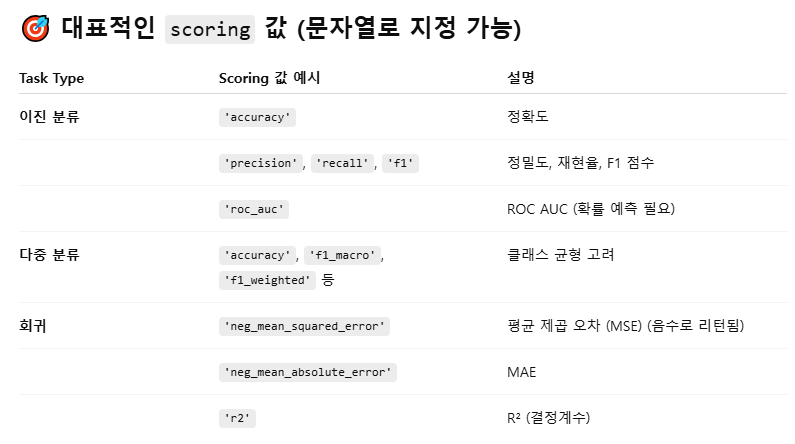

In [106]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

est = np.arange(10, 100, 10)
md = list(np.arange(3, 15, 2)) # + [None]

print(est)
print(md)
param_grid = {
    'n_estimators': est,
    'max_depth': md,
    'learning_rate': [0.01, 0.1, 0.2, 0.5]
}


xgb_model = XGBClassifier()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

grid = GridSearchCV(estimator=xgb_model,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='f1',
                    verbose=1)

grid.fit(df2.drop(['target'], axis=1), df2['target'])

# 결과
print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

[10 20 30 40 50 60 70 80 90]
[3, 5, 7, 9, 11, 13]
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best parameters: {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 20}
Best score: 0.9167809207950137


[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:   59.6s finished
